In [3]:
#Note: re-run the same time series analysis that was done with 311 air complaints to see if there are any differences when looking at 
#noise complaints

In [2]:
#import packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
# suppress warning
import warnings
warnings.filterwarnings('ignore')
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy
from sklearn.metrics import r2_score
from statsmodels.graphics.tsaplots import plot_acf

## Data Cleaning: 311 Noise Complaints
Note: aggregate by 6 month intervals and community district to match with NYC air quality data

In [18]:
#Source: https://data.cityofnewyork.us/Social-Services/311-Service-Requests-from-2010-to-Present/erm2-nwe9
#filter for unique key - complaint type that contains 'air'
complaints_noise=pd.read_csv("311_Service_Requests_from_2010_to_Present_Noise.csv")

In [19]:
import os
file_size = os.path.getsize('311_Service_Requests_from_2010_to_Present_Noise.csv')
print("File Size is :", file_size, "bytes")

File Size is : 2549448263 bytes


In [20]:
len(complaints_noise)

4389106

In [21]:
complaints_noise.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,23987526,09/09/2012 02:31:54 PM,09/09/2012 08:42:45 PM,NYPD,New York City Police Department,Noise - Residential,Loud Television,Residential Building/House,10460.0,1877 GUERLAIN STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.839989,-73.864155,"(40.83998863092911, -73.8641553785763)"
1,23987527,09/09/2012 09:52:19 AM,09/09/2012 02:09:52 PM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,10025.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.801172,-73.961457,"(40.8011722776532, -73.9614570576982)"
2,23987529,09/09/2012 05:46:19 PM,09/09/2012 08:18:56 PM,NYPD,New York City Police Department,Noise - Vehicle,Car/Truck Horn,Street/Sidewalk,10003.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.731739,-73.991459,"(40.73173920407658, -73.99145946208291)"
3,23987577,09/09/2012 03:20:30 PM,09/09/2012 11:33:26 PM,NYPD,New York City Police Department,Noise - Commercial,Loud Music/Party,Store/Commercial,10452.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.846266,-73.920578,"(40.84626628126276, -73.92057756119691)"
4,23987578,09/09/2012 12:01:54 PM,09/09/2012 01:06:55 PM,NYPD,New York City Police Department,Noise - House of Worship,Loud Music/Party,House of Worship,10065.0,411 EAST 68 STREET,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.765039,-73.957363,"(40.76503915141787, -73.95736259757767)"


In [22]:
#check unique complaint types
complaints_noise['Complaint Type'].value_counts()
#check number of records
#len(complaints_noise)

Noise - Residential         2317524
Noise - Street/Sidewalk      710383
Noise                        535487
Noise - Commercial           403917
Noise - Vehicle              317960
Noise - Park                  43863
Noise - Helicopter            31458
Noise Survey                  16303
Noise - House of Worship      10503
Collection Truck Noise         1708
Name: Complaint Type, dtype: int64

In [23]:
complaints_noise['Descriptor'].value_counts()

Loud Music/Party                                                           2414490
Banging/Pounding                                                            639056
Loud Talking                                                                370775
Noise: Construction Before/After Hours (NM1)                                221412
Car/Truck Music                                                             194734
Noise, Barking Dog (NR5)                                                     74708
Noise: Construction Equipment (NC1)                                          74225
Car/Truck Horn                                                               73910
Engine Idling                                                                68578
Loud Television                                                              42605
Noise: air condition/ventilation equipment (NV1)                             39040
Noise: Jack Hammering (NC2)                                                  35993
Nois

Note: due to the large number or noise related complaints - filter out by descriptor to make a bit more manageable.

In [24]:
#copy original data frame to have on file but edit complaints_noise in cleaning steps
complaints_noiseC = complaints_noise.copy()

In [25]:
#create list of unique descriptor to see which ones we want to filter out
descriptor_list = list(complaints_noise['Descriptor'].unique())
descriptor_list

['Loud Television',
 'Car/Truck Horn',
 'Loud Music/Party',
 'Banging/Pounding',
 'Loud Talking',
 'Car/Truck Music',
 'Noise, Ice Cream Truck (NR4)',
 'Noise: Construction Before/After Hours (NM1)',
 'Noise: Construction Equipment (NC1)',
 'Noise: Jack Hammering (NC2)',
 'People Created Noise',
 'Noise: Alarms (NR3)',
 'Horn Honking Sign Requested (NR9)',
 'Noise, Barking Dog (NR5)',
 'Noise: Boat(Engine,Music,Etc) (NR10)',
 'Noise: air condition/ventilation equipment (NV1)',
 'Engine Idling',
 'Noise, Other Animals (NR6)',
 'Noise: Private Carting Noise (NQ1)',
 'Noise:  lawn care equipment (NCL)',
 'Noise: Manufacturing Noise (NK1)',
 'Other',
 'NYPD',
 'Noise: Other Noise Sources (Use Comments) (NZZ)',
 'News Gathering',
 '21 Collection Truck Noise',
 'Noise: Air Condition/Ventilation Equip, Commercial (NJ2)',
 'Noise: Loud Music/Nighttime(Mark Date And Time) (NP1)',
 'Noise: Loud Music/Daytime (Mark Date And Time) (NN1)',
 'Noise: Air Condition/Ventilation Equip, Residential (NJ1)

In [26]:
descriptor_filter = ['Banging/Pounding','Noise: Construction Before/After Hours (NM1)',
                      'Noise: Construction Equipment (NC1)', 'Engine Idling',
                      'Noise: air condition/ventilation equipment (NV1)',
                      'Noise: Jack Hammering (NC2)', 'Other', 'Noise: Private Carting Noise (NQ1)',
                      'Noise: Air Condition/Ventilation Equip, Commercial (NJ2)', 'Noise:  lawn care equipment (NCL)',
                      'Noise: Air Condition/Ventilation Equip, Residential (NJ1)', 'Noise: Manufacturing Noise (NK1)',
                      '21 Collection Truck Noise', 'Noise: Vehicle (NR2)']

In [27]:
complaints_noise = complaints_noise.loc[(complaints_noise['Descriptor']).isin(descriptor_filter)]

In [29]:
#nice - cuts down data set significantly
len(complaints_noise)

1136855

In [30]:
complaints_noise['Complaint Type'].value_counts()

Noise - Residential         594737
Noise                       399902
Noise - Vehicle              68578
Noise - Commercial           43048
Noise - Helicopter           27611
Collection Truck Noise        1708
Noise - House of Worship      1271
Name: Complaint Type, dtype: int64

In [31]:
#edit and create date columns to aggegreate air quality complaints by date and season
complaints_noise['Created Date'] = pd.to_datetime(complaints_noise['Created Date'])
complaints_noise['date'] = complaints_noise['Created Date'].dt.date
complaints_noise['year'] = complaints_noise['Created Date'].dt.year
complaints_noise['month'] = complaints_noise['Created Date'].dt.month
complaints_noise['day'] = complaints_noise['Created Date'].dt.day
#create season column - note: months 12-5 are winter and 6-11 are summer
complaints_noise['season'] = 'winter'
complaints_noise.loc[(complaints_noise['month'] > 5) & (complaints_noise['month'] < 12), 'season'] = 'summer'
#check to make sure worked - looks good
#complaints_311.loc[(complaints_311['season'] == 'summer')]

In [32]:
complaints_noise['Incident Zip'].value_counts()

11201.0    22488
10016.0    22202
11226.0    20539
10025.0    19087
10011.0    18939
           ...  
10171.0        1
10168.0        1
10166.0        1
10155.0        1
0.0            1
Name: Incident Zip, Length: 230, dtype: int64

In [ ]:
noise_filteredDescriptors = complaints_noise['Descriptor']isin[descriptor_filter]

## Time Series Analysis: 311 Noise Complaints

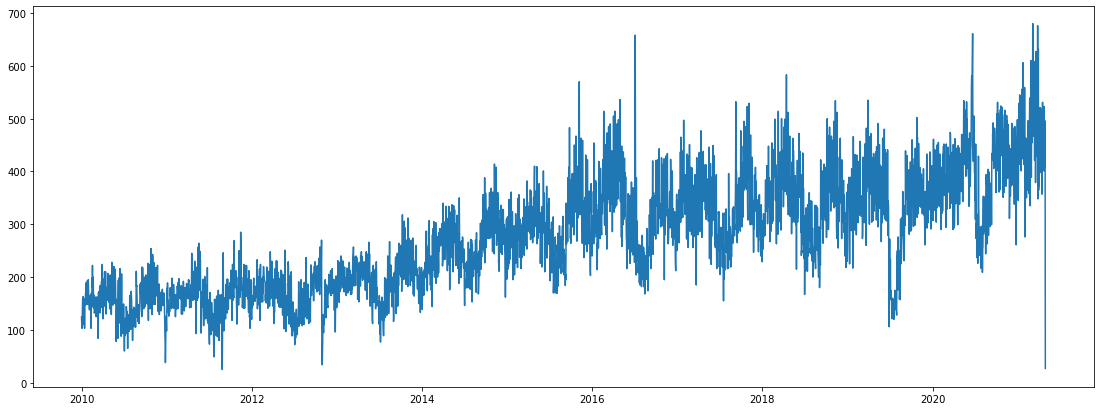

In [36]:
#first do general time series analysis (across all geographies) by day to see if we can detect overall trend
complaintsDaily = complaints_noise['date'].groupby(complaints_noise['date']).count().reset_index(name='count')
complaintsDaily
plt.figure(figsize = (19,7))
plt.plot(complaintsDaily['date'],complaintsDaily['count'])

Looks uniform with an spike in 311 noise complaints happening during 2021. Next, look at linear regression to see if we can determine a trend over the past 10 years.

In [37]:
lm_total=sm.OLS(complaintsDaily['count'],sm.add_constant(complaintsDaily.index)).fit()
print(lm_total.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.639
Model:                            OLS   Adj. R-squared:                  0.639
Method:                 Least Squares   F-statistic:                     7307.
Date:                Fri, 30 Apr 2021   Prob (F-statistic):               0.00
Time:                        15:42:56   Log-Likelihood:                -23035.
No. Observations:                4137   AIC:                         4.607e+04
Df Residuals:                    4135   BIC:                         4.609e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        128.9315      1.971     65.427      0.0

In [38]:
from datetime import date

complaintsDaily['date'] = pd.to_datetime(complaintsDaily['date'])
pd.Timestamp(date(2002,1,1))

Timestamp('2002-01-01 00:00:00')

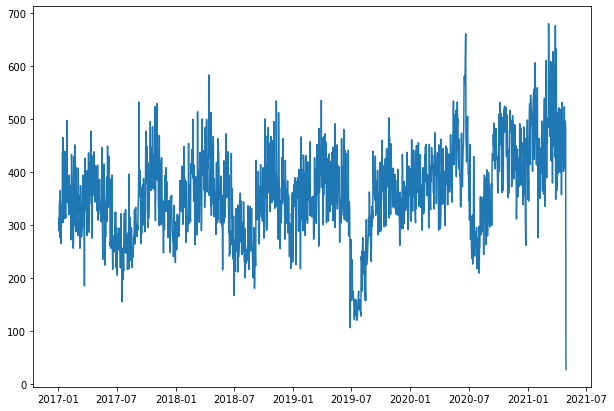

In [39]:
#now let's look over the past three years
complaintsDaily_current = complaintsDaily.loc[complaintsDaily['date'] > pd.Timestamp(date(2017,1,1))]
plt.figure(figsize = (10,7))
plt.plot(complaintsDaily_current['date'],complaintsDaily_current['count'])

In [40]:
complaintsDaily_current.head()

,date,count
2558,2017-01-02,312
2559,2017-01-03,289
2560,2017-01-04,332
2561,2017-01-05,346
2562,2017-01-06,276


In [41]:
lm_current=sm.OLS(complaintsDaily_current['count'],sm.add_constant(complaintsDaily_current.index)).fit()
print(lm_current.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     241.5
Date:                Fri, 30 Apr 2021   Prob (F-statistic):           8.91e-51
Time:                        15:42:59   Log-Likelihood:                -9112.4
No. Observations:                1579   AIC:                         1.823e+04
Df Residuals:                    1577   BIC:                         1.824e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        136.9943     14.488      9.456      0.0

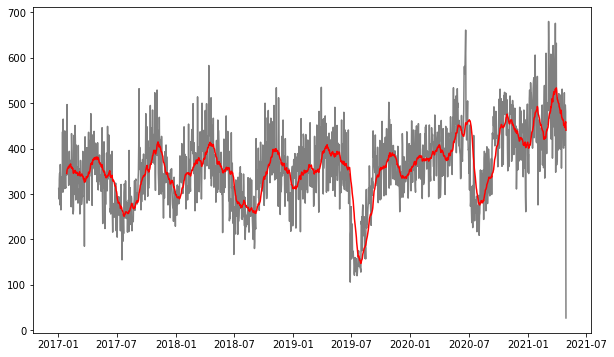

In [42]:
#plot the data along with the seasonal(bi-annual)moving average
plt.figure(figsize = (10,6))
plt.plot(complaintsDaily_current['date'],complaintsDaily_current['count'], color = 'gray')
plt.plot(complaintsDaily_current['date'],complaintsDaily_current['count'].rolling(window = 26).mean(), color = 'red')

Decompose the data into the trend, repeated (seasonal) component over 26 week (approx 6 months) period and the residual fluctuations.

In [43]:
complaintsDaily_current = complaintsDaily_current.reset_index()
complaintsDaily_current = complaintsDaily_current.drop(columns = 'index')
complaintsDaily_current.head()

,date,count
0,2017-01-02,312
1,2017-01-03,289
2,2017-01-04,332
3,2017-01-05,346
4,2017-01-06,276


In [44]:
complaintsDaily_current = complaintsDaily_current.set_index('date')

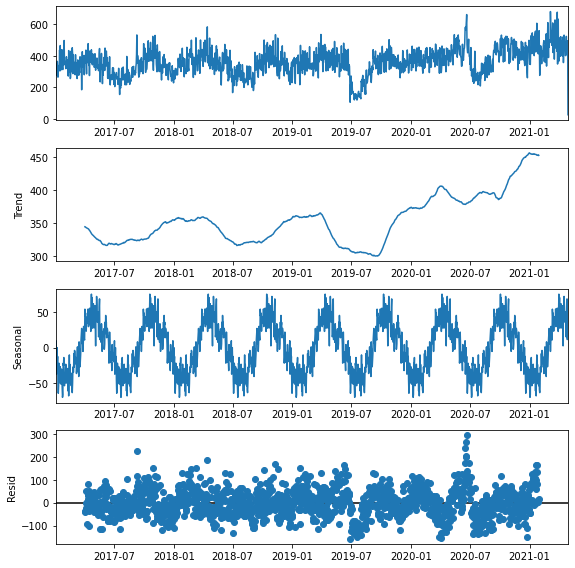

In [45]:
matplotlib.rcParams['figure.figsize'] = [8, 8]
res = sm.tsa.seasonal_decompose(complaintsDaily_current,model='additive',freq=180) #about 180 days per season (summer/winter)
res.plot()
plt.show()

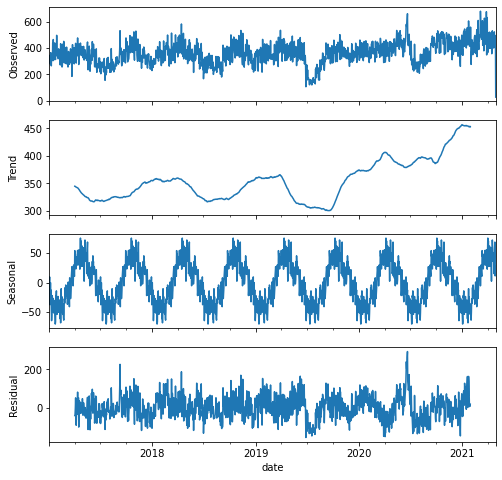

In [46]:
#redo of code above - not sure why residual is scatter
fig, axes = plt.subplots(4, 1, sharex=True)
res.observed.plot(ax=axes[0], legend=False)
res.trend.plot(ax=axes[1], legend=False)
res.seasonal.plot(ax=axes[2], legend=False)
res.resid.plot(ax=axes[3], legend=False)

axes[0].set_ylabel('Observed')
axes[1].set_ylabel('Trend')
axes[2].set_ylabel('Seasonal')
axes[3].set_ylabel('Residual')

plt.show()

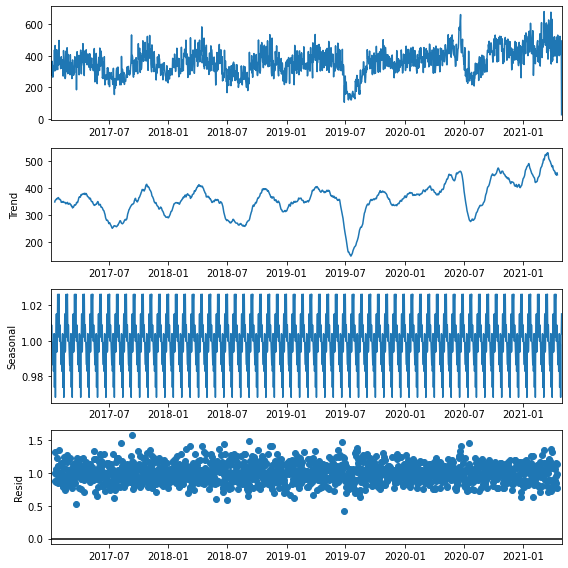

In [47]:
#check multiplicative instead of additive
matplotlib.rcParams['figure.figsize'] = [8, 8]
res = sm.tsa.seasonal_decompose(complaintsDaily_current,model='multiplicative',freq=26)
res.plot()
plt.show()

Now, determine the strongest period length.

In [48]:
complaintsDaily_current = complaintsDaily_current.reset_index()
complaintsDaily_current.head()

,date,count
0,2017-01-02,312
1,2017-01-03,289
2,2017-01-04,332
3,2017-01-05,346
4,2017-01-06,276


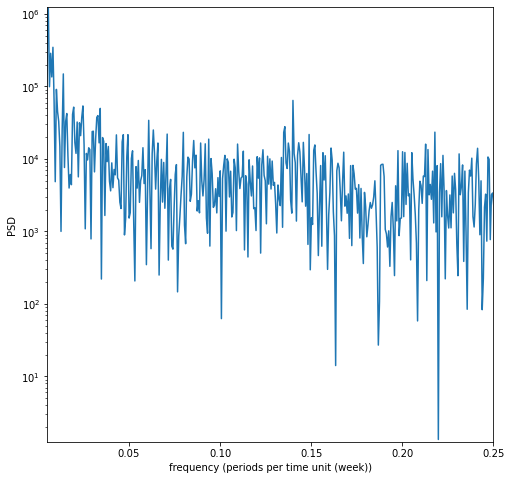

Strongest period length = 175.44444444444446


In [49]:
f, PSD = scipy.signal.periodogram(complaintsDaily_current['count'])
plt.semilogy(f, PSD)
plt.xlabel('frequency (periods per time unit (week))')
plt.ylabel('PSD')
plt.xlim(0.005,0.25) #show frequencies within 1/4..1/200, periods of 4-200 weeks
plt.ylim(max(PSD)/1e6,max(PSD)) #show strength up to 1e-6 of the max
#filter outputs - periods shorter than 4 years (approx 200 weeks)
PSD = PSD[f>0.005]
f = f[f>0.005]
plt.show()
print('Strongest period length = {}'.format(1/f[np.argmax(PSD)])) #report the length of the strongest period
#transformting the frequency into the period length, using 1=frequency (number of periods)*period length

Text(0.5, 1.0, '311 Noise Complaints by Season')

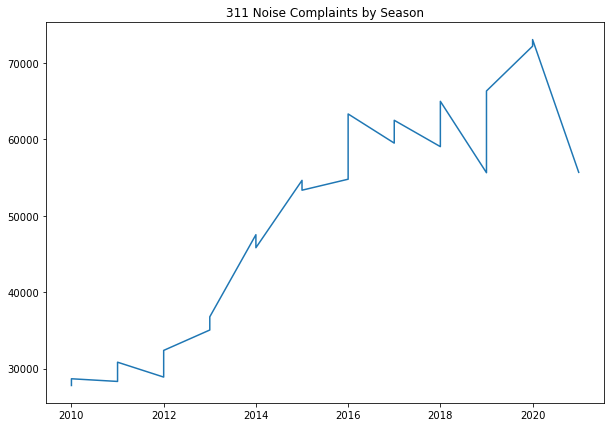

In [50]:
#Now, visualize complaints by season
complaints_seasonal = complaints_noise.groupby(['year','season'])['Unique Key'].count().reset_index()
complaints_seasonal.head()

#plot
plt.figure(figsize = (10,7))
plt.plot(complaints_seasonal['year'], complaints_seasonal['Unique Key'])
plt.title('311 Noise Complaints by Season')

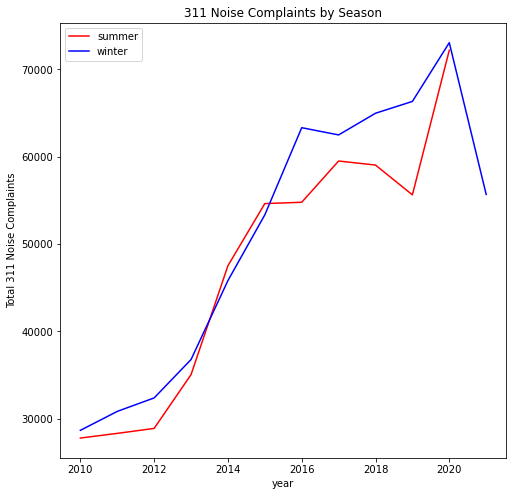

In [51]:
#separate df for summer and winter to plot
complaints_summer = complaints_seasonal.loc[complaints_seasonal['season'] == 'summer']
complaints_summer = complaints_summer[['year','Unique Key']]
complaints_winter = complaints_seasonal.loc[complaints_seasonal['season'] == 'winter']
complaints_winter = complaints_winter[['year','Unique Key']]

#plot
plt.plot(complaints_summer.year, complaints_summer['Unique Key'], color='red', label='summer')
plt.plot(complaints_winter.year, complaints_winter['Unique Key'], color='blue', label= 'winter')

plt.xlabel('year')
plt.ylabel('Total 311 Noise Complaints')
plt.title('311 Noise Complaints by Season')
plt.legend()

In [52]:
#will make more of a difference when we have this amount
len(complaints_seasonal)

23

## 311 Noise Complaint Spatial Join with Community District

In [53]:
import geopandas as gpd
#community district shape file
cd = gpd.read_file('data/shp/nycd.shp')
cd.head()

,BoroCD,Shape_Leng,Shape_Area,geometry
0,101,74168.587892,4.268912e+07,"MULTIPOLYGON (((972081.788 190733.467, 972184...."
1,102,34130.595277,3.768921e+07,"POLYGON ((985125.733 207917.071, 986018.960 20..."
2,103,30695.640963,4.687978e+07,"POLYGON ((992073.467 203714.076, 992068.667 20..."
3,104,67623.669901,4.931172e+07,"POLYGON ((985929.324 220967.002, 985995.954 22..."
4,105,35288.188510,4.379033e+07,"POLYGON ((991725.244 217725.299, 992169.505 21..."


In [54]:
#create geodataframe for 311 noise complaints
gdf = gpd.GeoDataFrame(complaints_noise,crs='EPSG:4326', geometry=gpd.points_from_xy(complaints_noise.Longitude, complaints_noise.Latitude))
gdf.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Segment,Latitude,Longitude,Location,date,year,month,day,season,geometry
6,23987580,2012-09-09 20:09:08,09/09/2012 08:27:18 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,10467.0,806 EAST 222 STREET,...,NaN,40.884594,-73.858213,"(40.88459386072777, -73.85821278582762)",2012-09-09,2012,9,9,summer,POINT (-73.85821 40.88459)
7,23987581,2012-09-09 13:41:38,09/09/2012 09:50:19 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11210.0,2400 NOSTRAND AVENUE,...,NaN,40.626023,-73.946741,"(40.62602322459271, -73.9467413075762)",2012-09-09,2012,9,9,summer,POINT (-73.94674 40.62602)
8,23987582,2012-09-09 12:53:30,09/09/2012 02:10:55 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,10453.0,1645 GRAND AVENUE,...,NaN,40.846990,-73.915144,"(40.846989759713665, -73.91514421990779)",2012-09-09,2012,9,9,summer,POINT (-73.91514 40.84699)
9,23987583,2012-09-09 14:11:20,09/09/2012 03:15:06 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11373.0,86-45 ST JAMES AVENUE,...,NaN,40.740134,-73.878223,"(40.74013446721195, -73.87822332055042)",2012-09-09,2012,9,9,summer,POINT (-73.87822 40.74013)
10,23987584,2012-09-09 16:38:19,09/09/2012 06:22:18 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11426.0,90-02 247 STREET,...,NaN,40.726522,-73.721380,"(40.72652224941577, -73.72138043110519)",2012-09-09,2012,9,9,summer,POINT (-73.72138 40.72652)


In [55]:
#drop lat/lon NA's to merge with cd shape file
gdf = gdf.dropna(subset=['Latitude','Longitude'])
gdf.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,Bridge Highway Segment,Latitude,Longitude,Location,date,year,month,day,season,geometry
6,23987580,2012-09-09 20:09:08,09/09/2012 08:27:18 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,10467.0,806 EAST 222 STREET,...,NaN,40.884594,-73.858213,"(40.88459386072777, -73.85821278582762)",2012-09-09,2012,9,9,summer,POINT (-73.85821 40.88459)
7,23987581,2012-09-09 13:41:38,09/09/2012 09:50:19 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11210.0,2400 NOSTRAND AVENUE,...,NaN,40.626023,-73.946741,"(40.62602322459271, -73.9467413075762)",2012-09-09,2012,9,9,summer,POINT (-73.94674 40.62602)
8,23987582,2012-09-09 12:53:30,09/09/2012 02:10:55 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,10453.0,1645 GRAND AVENUE,...,NaN,40.846990,-73.915144,"(40.846989759713665, -73.91514421990779)",2012-09-09,2012,9,9,summer,POINT (-73.91514 40.84699)
9,23987583,2012-09-09 14:11:20,09/09/2012 03:15:06 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11373.0,86-45 ST JAMES AVENUE,...,NaN,40.740134,-73.878223,"(40.74013446721195, -73.87822332055042)",2012-09-09,2012,9,9,summer,POINT (-73.87822 40.74013)
10,23987584,2012-09-09 16:38:19,09/09/2012 06:22:18 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11426.0,90-02 247 STREET,...,NaN,40.726522,-73.721380,"(40.72652224941577, -73.72138043110519)",2012-09-09,2012,9,9,summer,POINT (-73.72138 40.72652)


In [57]:
#NaN with cd info so check coordinate system of cd
cd.crs

<Projected CRS: EPSG:2263>
Name: NAD83 / New York Long Island (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - New York - SPCS - Long Island
- bounds: (-74.26, 40.47, -71.8, 41.3)
Coordinate Operation:
- name: SPCS83 New York Long Island zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [58]:
#change cd coordinate system to match gdf
cd = cd.to_crs('EPSG:4326')
#gdf = gpd.GeoDataFrame(complaints_311,crs='EPSG:4326', geometry=gpd.points_from_xy(complaints_311.Longitude, complaints_311.Latitude))
cd.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [61]:
#spatial join
joined_complaints = gpd.sjoin(gdf, cd, op='intersects', how='left')
joined_complaints.head() #looks good

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,...,date,year,month,day,season,geometry,index_right,BoroCD,Shape_Leng,Shape_Area
6,23987580,2012-09-09 20:09:08,09/09/2012 08:27:18 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,10467.0,806 EAST 222 STREET,...,2012-09-09,2012,9,9,summer,POINT (-73.85821 40.88459),22.0,212.0,83997.978975,1.548975e+08
7,23987581,2012-09-09 13:41:38,09/09/2012 09:50:19 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11210.0,2400 NOSTRAND AVENUE,...,2012-09-09,2012,9,9,summer,POINT (-73.94674 40.62602),39.0,314.0,49291.791980,8.217567e+07
8,23987582,2012-09-09 12:53:30,09/09/2012 02:10:55 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,10453.0,1645 GRAND AVENUE,...,2012-09-09,2012,9,9,summer,POINT (-73.91514 40.84699),16.0,205.0,29443.048433,3.831698e+07
9,23987583,2012-09-09 14:11:20,09/09/2012 03:15:06 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11373.0,86-45 ST JAMES AVENUE,...,2012-09-09,2012,9,9,summer,POINT (-73.87822 40.74013),49.0,404.0,37018.373179,6.573966e+07
10,23987584,2012-09-09 16:38:19,09/09/2012 06:22:18 PM,NYPD,New York City Police Department,Noise - Residential,Banging/Pounding,Residential Building/House,11426.0,90-02 247 STREET,...,2012-09-09,2012,9,9,summer,POINT (-73.72138 40.72652),58.0,413.0,140593.306905,3.504694e+08


In [62]:
#check for Boro CD's that are NaN 
len(joined_complaints.loc[joined_complaints['BoroCD']=='NaN'])

0

In [63]:
#check number of cd's in file
joined_complaints.BoroCD.value_counts()

107.0    47831
104.0    45251
108.0    41444
106.0    39949
112.0    39719
         ...  
480.0       16
356.0       12
228.0        8
484.0        6
483.0        3
Name: BoroCD, Length: 71, dtype: int64

In [64]:
#aggregating # of complaints, by type, by CD, by season
seasonal_noise_type_CD = joined_complaints.groupby(['year','season','BoroCD', 'Descriptor'])['Unique Key'].count().reset_index()

In [65]:
seasonal_noise_CD = joined_complaints.groupby(['year','season','BoroCD'])['Unique Key'].count().reset_index()

In [66]:
seasonal_noise_type_CD.to_csv('complaints_noise_by_type_CD.csv')
seasonal_noise_CD.to_csv('complaints_noise_by_CD.csv')